Arjun Bhan

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#1

In [2]:
df = pd.read_csv("https://foxweb.marist.edu/users/jf4n/DATA_FILES/drug_consumption.csv")

#2 

In [3]:
predictors=df.iloc[:,0:12]
target=df['Hallucinogens']

#3


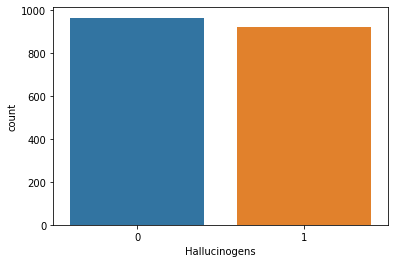

In [4]:
ax = sns.countplot(x=target, data=df)

#4 and 5

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.33, random_state=42)

XGBoost 

In [6]:
import time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

In [7]:
xgb = XGBClassifier(learning_rate=0.02, 
                    objective='binary:logistic',
                    silent=True, 
                    nthread=1)

In [8]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [9]:
def searchCV (search_type ='random', folds=10, param_comb = 20):
   
  if search_type =='random':
    search_ = RandomizedSearchCV(xgb, 
                                       param_distributions=params, 
                                       n_iter=param_comb, 
                                       scoring='roc_auc', 
                                       n_jobs=-1, 
                                       cv=folds,
                                       verbose=3, 
                                       random_state=42)
  elif search_type =='grid':
    search_ = GridSearchCV(estimator=xgb,
                                param_grid=params,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=folds,
                                verbose=3) 
  return search_

In [10]:
start_time = time.time()
folds = 10
param_comb = 20
srchCV = searchCV (search_type ='random', folds=10, param_comb = 20)
srchCV.fit(X_train, y_train)
print(f"Execution time:{(time.time() - start_time):.2f} seg ---")

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Execution time:19.36 seg ---


In [11]:
print('\n Best estimator:')
print(srchCV.best_estimator_)
print(f'\n Best AUC for {folds:d}-fold search:')
print(srchCV.best_score_ )
print('\n Best hyperparameters:')
print(srchCV.best_params_)
results = pd.DataFrame(srchCV.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 Best estimator:
XGBClassifier(colsample_bytree=0.6, gamma=0.5, learning_rate=0.02, max_depth=4,
              nthread=1, silent=True, subsample=0.6)

 Best AUC for 10-fold search:
0.8748636745767893

 Best hyperparameters:
{'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.5, 'colsample_bytree': 0.6}


In [12]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min_child_weight,param_max_depth,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.229126,0.094138,0.009046,0.003890,0.8,10,4,1.5,0.6,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.884501,0.937904,0.889899,0.896212,0.904293,0.843632,0.894325,0.817907,0.873140,0.784363,0.872618,0.042844,10
1,0.179071,0.046946,0.007605,0.004367,1,1,3,2,0.8,"{'subsample': 1.0, 'min_child_weight': 1, 'max...",0.869598,0.941381,0.869697,0.882323,0.904672,0.844641,0.905170,0.819168,0.874023,0.793443,0.870411,0.040974,15
2,0.171456,0.037436,0.006645,0.002719,0.8,10,3,5,1,"{'subsample': 0.8, 'min_child_weight': 10, 'ma...",0.871833,0.939642,0.877020,0.888636,0.893813,0.844136,0.897100,0.817150,0.876545,0.783480,0.868936,0.041870,20
3,0.120415,0.007937,0.005178,0.000218,0.6,10,3,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.888475,0.940387,0.887374,0.894192,0.905808,0.846406,0.896847,0.825725,0.871375,0.786381,0.874297,0.041848,5
4,0.140768,0.006783,0.004812,0.000380,0.6,10,4,1,0.6,"{'subsample': 0.6, 'min_child_weight': 10, 'ma...",0.886239,0.940636,0.892677,0.895960,0.906566,0.846406,0.897100,0.825473,0.871627,0.784363,0.874705,0.042623,2


In [13]:
predictions = srchCV.predict(X_test)

probs = srchCV.predict_proba(X_test)[:,1]

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score 
from sklearn.metrics import confusion_matrix,roc_curve, auc

In [15]:
accuracy = accuracy_score(y_test, predictions)
precision=precision_score(y_test, predictions, )
recall=recall_score(y_test, predictions)
specificity=recall_score(y_test, predictions, pos_label=0)
roc = roc_auc_score(y_test, probs)

print("\n")
print(f"Accuracy.........: {accuracy * 100.0:.4f}")
print(f"Precision........: {precision *100:.4f}")
print(f"Recall...........: {recall * 100:.4f}")
print(f"FP Rate...........:{(1-specificity) * 100:.4f}")
print(f"ROC AUC (probs)..: {roc:.6f}")

cm = confusion_matrix(y_test, predictions)
print(f"Confusion matrix.:\n {cm}")



Accuracy.........: 78.6517
Precision........: 78.4810
Recall...........: 79.2332
FP Rate...........:21.9355
ROC AUC (probs)..: 0.859528
Confusion matrix.:
 [[242  68]
 [ 65 248]]


In [16]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

In [17]:
roc_df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': threshold})
roc_df

,tpr,fpr,threshold
0,0.000000,0.000000,1.884657
1,0.000000,0.003226,0.884657
2,0.031949,0.003226,0.877541
3,0.031949,0.006452,0.877411
4,0.051118,0.006452,0.872794
...,...,...,...
203,0.993610,0.922581,0.137479
204,0.996805,0.922581,0.136334
205,0.996805,0.925806,0.135984
206,1.000000,0.925806,0.135597


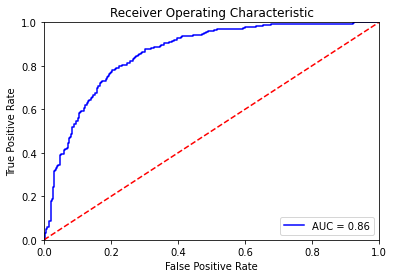

In [18]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROCcuve.png')
plt.show()

Random Forest

In [19]:
import time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [20]:
RFC = RandomForestClassifier()

In [21]:
params = {
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6, None],
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [50,100,200],
        }

In [22]:
def searchCV (search_type ='random', folds=10, param_comb = 20):
   
  if search_type =='random':
    search_ = RandomizedSearchCV(RFC, 
                                       param_distributions=params, 
                                       n_iter=param_comb, 
                                       scoring='roc_auc', 
                                       n_jobs=-1, 
                                       cv=folds,
                                       verbose=3, 
                                       random_state=42)
  elif search_type =='grid':
    search_ = GridSearchCV(estimator=RFC,
                                param_grid=params,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=folds,
                                verbose=3) 
  return search_

In [23]:
start_time = time.time()
folds = 10
param_comb = 20
srchCV = searchCV (search_type ='random', folds=10, param_comb = 20)
srchCV.fit(X_train, y_train)
print(f"Execution time:{(time.time() - start_time):.2f} seg ---")

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Execution time:41.63 seg ---


In [24]:
print('\n Best estimator:')
print(srchCV.best_estimator_)
print(f'\n Best AUC for {folds:d}-fold search:')
print(srchCV.best_score_ )
print('\n Best hyperparameters:')
print(srchCV.best_params_)
results = pd.DataFrame(srchCV.cv_results_)
results.to_csv('RFC-random-grid-search-results-01.csv', index=False)


 Best estimator:
RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       n_estimators=200)

 Best AUC for 10-fold search:
0.8736449615957813

 Best hyperparameters:
{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 5, 'criterion': 'entropy'}


In [25]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.288326,0.016796,0.026803,0.004092,100,auto,2,entropy,"{'n_estimators': 100, 'max_features': 'auto', ...",0.878788,0.936413,0.868939,0.873737,0.907071,0.840101,0.887264,0.823455,0.863556,0.785876,0.866520,0.040290,13
1,0.291081,0.008051,0.025704,0.000906,100,auto,3,gini,"{'n_estimators': 100, 'max_features': 'auto', ...",0.882762,0.939394,0.870960,0.884343,0.905303,0.838335,0.893821,0.820177,0.874401,0.785876,0.869537,0.041926,9
2,0.707497,0.009304,0.047172,0.004976,200,log2,6,entropy,"{'n_estimators': 200, 'max_features': 'log2', ...",0.882017,0.935171,0.884848,0.890152,0.910354,0.843884,0.890290,0.821438,0.867087,0.787137,0.871238,0.041180,5
3,0.265102,0.006984,0.026492,0.004182,100,sqrt,1,entropy,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.874193,0.931197,0.859470,0.869444,0.894444,0.829760,0.885120,0.814880,0.861791,0.764565,0.858486,0.043836,19
4,0.318135,0.009797,0.028019,0.003754,100,sqrt,4,entropy,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.881769,0.939642,0.886364,0.890909,0.904545,0.839596,0.892055,0.822699,0.874653,0.793947,0.872618,0.040339,3


In [26]:
predictions = srchCV.predict(X_test)

probs = srchCV.predict_proba(X_test)[:,1]

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score 
from sklearn.metrics import confusion_matrix,roc_curve, auc

In [28]:
accuracy = accuracy_score(y_test, predictions)
precision=precision_score(y_test, predictions, )
recall=recall_score(y_test, predictions)
specificity=recall_score(y_test, predictions, pos_label=0)
roc = roc_auc_score(y_test, probs)

print("\n")
print(f"Accuracy.........: {accuracy * 100.0:.4f}")
print(f"Precision........: {precision *100:.4f}")
print(f"Recall...........: {recall * 100:.4f}")
print(f"FP Rate...........:{(1-specificity) * 100:.4f}")
print(f"ROC AUC (probs)..: {roc:.6f}")

cm = confusion_matrix(y_test, predictions)
print(f"Confusion matrix.:\n {cm}")



Accuracy.........: 79.6148
Precision........: 79.6178
Recall...........: 79.8722
FP Rate...........:20.6452
ROC AUC (probs)..: 0.861713
Confusion matrix.:
 [[246  64]
 [ 63 250]]


In [29]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

In [30]:
roc_df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': threshold})
roc_df

,tpr,fpr,threshold
0,0.000000,0.000000,1.939851
1,0.000000,0.003226,0.939851
2,0.022364,0.003226,0.925111
3,0.022364,0.006452,0.924377
4,0.031949,0.006452,0.922672
...,...,...,...
169,0.993610,0.887097,0.108795
170,0.996805,0.887097,0.108727
171,0.996805,0.893548,0.105431
172,1.000000,0.893548,0.105236


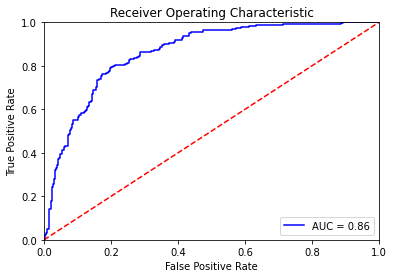

In [31]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROCcuve.png')
plt.show()

6

The XGBoost classifier performed better in every tested metric than the RandomForest classifier. 